# Import libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import codecs, cv2, datetime, glob, itertools, keras, os, pickle
import re, sklearn, string, sys, tensorflow, time
from random import randint
from keras import backend as K, regularizers, optimizers
from keras.models import load_model, Sequential
from keras.layers import MaxPooling2D, Convolution2D, Activation, Dropout, Flatten, Dense, InputLayer,MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from keras.layers.convolutional import Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.constraints import maxnorm
from keras.optimizers import SGD,RMSprop
from keras import backend as K

# parametres

In [0]:
K.set_image_dim_ordering('tf')

# dimension de l'image
img_width  = 28
img_height = 28
channels   = 1

#parametres d'apprentissage
batch_size = 250
num_epochs = 80 #80
iterations = 7            # nombre modele entrainé
number_of_augmentation = 2 # defines the amount of additional augmentation images of one image

#Data
train_data_dir      = 'data/train/fashion_mnist'
test_data_dir       = 'data/test/fashion_mnist'
classes             = {0: 'T-shirt/top', 
                       1: 'Trouser', 
                       2: 'Pullover', 
                       3: 'Dress', 
                       4: 'Coat',
                       5: 'Sandal', 
                       6: 'Shirt', 
                       7: 'Sneaker', 
                       8: 'Bag', 
                       9: 'Ankle boot'
                      }
num_classes         = len(classes)
classes_fashion     = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
                       'Sandal','Shirt','Sneaker','Bag','Ankle boot']

# Création Model Réseau convolutif

### INPUT -> [CONV -> RELU -> POOL] * 3

In [18]:
def create_model_0():
    cnn_0 = Sequential()
    
    #dimension de la couche d'entrée =  la dimension de l'image
    cnn_0.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalisation
    cnn_0.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn_0.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn_0.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_0.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn_0.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn_0.add(MaxPooling2D(pool_size=(2, 2)))


    # Dropout
    cnn_0.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn_0.add(Flatten())
    
    # Normalization
    cnn_0.add(BatchNormalization())

    cnn_0.add(Dense(num_classes, activation='softmax'))
    cnn_0.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),    # mettre optimizer='sgd'
                metrics=['accuracy'])

    return cnn_0

create_model_0().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_12 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 64)        1088      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 9, 9, 64)          65600     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 4, 4, 64)          0         
__________

###  INPUT -> FC (Implémente un classifieur linéaire)

In [19]:
def create_model_1():
    cnn_1 = Sequential()
    
    #dimension de la couche d'entrée =  la dimension de l'image
    cnn_1.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn_1.add(BatchNormalization())

    # Converting 3D feature to 1D feature Vektor
    cnn_1.add(Flatten())
    
    # Fully Connected Layer
    cnn_1.add(Dense(64, activation='relu'))
    
    # Normalisation
    cnn_1.add(BatchNormalization())

    cnn_1.add(Dense(num_classes, activation='softmax'))
    cnn_1.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),    # mettre optimizer='sgd'
                metrics=['accuracy'])

    return cnn_1

create_model_1().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
flatten_9 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                50240     
_________________________________________________________________
batch_normalization_15 (Batc (None, 64)                256       
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 51,150
Trainable params: 51,020
Non-trainable params: 130
_________________________________________________________________


### INPUT -> CONV -> RELU -> FC

In [20]:
def create_model_2():
    cnn_2 = Sequential()
    
    #dimension de la couche d'entrée = a la dimension de l'image
    cnn_2.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn_2.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn_2.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn_2.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_2.add(Dropout(0.1))

    # Converting 3D feature to 1D feature Vektor
    cnn_2.add(Flatten())

    # Fully Connected Layer
    cnn_2.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn_2.add(BatchNormalization())

    cnn_2.add(Dense(num_classes, activation='softmax'))
    cnn_2.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),    # mettre optimizer='sgd'
                metrics=['accuracy'])

    return cnn_2

create_model_2().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_16 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 12544)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                802880    
_________________________________________________________________
batch_normalization_17 (Batc (None, 64)                256       
__________

### CNN : INPUT -> [CONV -> RELU -> POOL] * 2 -> FC -> RELU -> FC

In [21]:
def create_model_3():
    cnn_3 = Sequential()
    
    #dimension de la couche d'entrée = a la dimension de l'image
    cnn_3.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn_3.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn_3.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn_3.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_3.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn_3.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn_3.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_3.add(Dropout(0.3))

    # Converting 3D feature to 1D feature Vektor
    cnn_3.add(Flatten())

    # Fully Connected Layer
    cnn_3.add(Dense(256, activation='relu'))

    # Dropout
    cnn_3.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn_3.add(Dense(64, activation='relu'))
    
    # Normalization
    cnn_3.add(BatchNormalization())

    cnn_3.add(Dense(num_classes, activation='softmax'))
    cnn_3.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),    # mettre optimizer='sgd'
                metrics=['accuracy'])

    return cnn_3

create_model_3().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_18 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        65600     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 5, 5, 64)          0         
__________

### INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] * 3 -> [FC -> RELU] 

In [22]:
def create_model_4():
    cnn_4 = Sequential()
    
    #dimension de la couche d'entrée = a la dimension de l'image
    cnn_4.add(InputLayer(input_shape=(img_height,img_width,channels)))
    
    # Normalization
    cnn_4.add(BatchNormalization())
    
    # Conv + Maxpooling
    cnn_4.add(Convolution2D(64, (4, 4), padding='same', activation='relu'))
    cnn_4.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_4.add(Dropout(0.1))
    
    # Conv + Maxpooling
    cnn_4.add(Convolution2D(64, (4, 4),padding='same', activation='relu'))
    cnn_4.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_4.add(Dropout(0.3))
    
    # Conv + Maxpooling
    cnn_4.add(Convolution2D(64, (4, 4), activation='relu'))
    cnn_4.add(MaxPooling2D(pool_size=(2, 2)))

    # Dropout
    cnn_4.add(Dropout(0.5))

    # Converting 3D feature to 1D feature Vektor
    cnn_4.add(Flatten())

    # Fully Connected Layer
    cnn_4.add(Dense(64, activation='relu'))

    # Dropout
    cnn_4.add(Dropout(0.5))
    
    # Fully Connected Layer
    cnn_4.add(Dense(32, activation='relu'))
    
    # Normalization
    cnn_4.add(BatchNormalization())

    cnn_4.add(Dense(num_classes, activation='softmax'))
    cnn_4.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(),    # mettre optimizer='sgd'
                metrics=['accuracy'])

    return cnn_4

create_model_4().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 64)        1088      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        65600     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 64)          0         
__________

###  INPUT -> [CONV -> RELU -> POOL] * 2->BN 

In [23]:
def create_model_5():
  cnn_5 = Sequential()
  cnn_5.add(InputLayer(input_shape=(img_height,img_width,channels)))
  cnn_5.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
  cnn_5.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', activation ='relu'))
  cnn_5.add(MaxPool2D(pool_size=(2,2)))
  cnn_5.add(Dropout(0.25))
  cnn_5.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  cnn_5.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
  cnn_5.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
  cnn_5.add(Dropout(0.25))
  cnn_5.add(Flatten())
  cnn_5.add(Dense(512, activation = "relu"))
  cnn_5.add(BatchNormalization())
  cnn_5.add(Dropout(0.5))
  cnn_5.add(Dense(10, activation = "softmax"))
  optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
  cnn_5.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
  return cnn_5

create_model_5().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 7, 7, 64)          0         
__________

### INPUT -> [CONV -> RELU -> POOL] * 3 -> [FC -> RELU] *2 avec sgd et contraint maxnorm

In [24]:

def create_model_6():
    # create model
    model = Sequential()
    model.add(InputLayer(input_shape=(img_height,img_width,channels)))
    model.add(Conv2D(32, (5, 5), input_shape=(img_height,img_width,channels), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(128, (1, 1), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Flatten())

    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    # Compile model
    lrate = 0.01
    decay = lrate / num_epochs
    sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model
create_model_6().summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 7, 7, 128)         8320      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 4, 4, 128)         0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 2048)              0         
__________

## Import Data

In [0]:
def shaping(data, target):
    data = np.array(data, dtype=np.uint8)
    target = np.array(target, dtype=np.uint8)
    data = data.reshape(data.shape[0], img_height, img_width, channels)
    target = np_utils.to_categorical(target, num_classes)
    data = data.astype('float32')
    data /= 255
    return data, target

In [0]:
df_test = pd.read_csv('fashion-mnist_test.csv')
df_train = pd.read_csv('fashion-mnist_train.csv')

In [0]:
train_data = df_train.drop(labels='label',axis=1).values
train_target = df_train["label"].values
test_data = df_test.drop(labels='label',axis=1).values
test_target = df_test["label"].values

In [0]:
train_data_shaped, train_target_shaped  = shaping(train_data, train_target)
test_data_shaped, test_target_shaped    = shaping(test_data, test_target)

In [29]:
train_data_shaped.shape

(60000, 28, 28, 1)

## Data visualisation

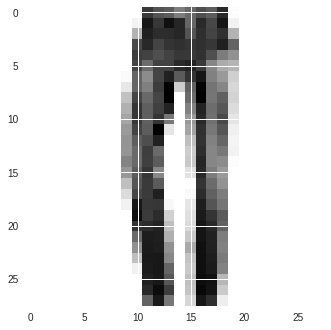

In [30]:
image=test_data_shaped
image=image.reshape(-1,28,28)
plt.imshow(image[1])

## Entrainement du des CNN

In [31]:
histories = []

for i in range(0,iterations):
    print('Running iteration: %i' % i)
    
    # Saving the best checkpoint for each iteration
    filepath="fashion_mnist-%i.hdf5" % i
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                                 save_best_only=True, mode='min')
    
    X_train, X_val, y_train, y_val = train_test_split(train_data_shaped, train_target_shaped,
                                                      test_size=0.2, random_state=42)

    if i == 0:
      print('create_model_0')
      cnn = create_model_0()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 1:
      print('create_model_1')
      cnn = create_model_1()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
     
    if i == 2:
      print('create_model_2')
      cnn = create_model_2()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 3:
      print('create_model_3')
      cnn = create_model_3()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 4:
      print('create_model_4')
      cnn = create_model_4()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 5:
      print('create_model_5')
      cnn = create_model_5()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 5:
      print('create_model_5')
      cnn = create_model_5()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 6:
      print('create_model_6')
      cnn = create_model_6()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
    if i == 7:
      print('create_model_7')
      cnn = create_model_7()
      history = cnn.fit(
          X_train,
          y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[
              #early_stopping,
              checkpoint
          ]
      )
      
      
      
    
    histories.append(history.history)

Running iteration: 0
create_model_0
Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/80
48000/48000 [==============================] - 10s 203us/step - loss: 0.6074 - acc: 0.7817 - val_loss: 0.4367 - val_acc: 0.8382

Epoch 00001: val_loss improved from inf to 0.43668, saving model to fashion_mnist-0.hdf5
Epoch 2/80
48000/48000 [==============================] - 5s 105us/step - loss: 0.3976 - acc: 0.8570 - val_loss: 0.3672 - val_acc: 0.8592

Epoch 00002: val_loss improved from 0.43668 to 0.36722, saving model to fashion_mnist-0.hdf5
Epoch 3/80
48000/48000 [==============================] - 5s 105us/step - loss: 0.3530 - acc: 0.8732 - val_loss: 0.3200 - val_acc: 0.8806

Epoch 00003: val_loss improved from 0.36722 to 0.31999, saving model to fashion_mnist-0.hdf5
Epoch 4/80
48000/48000 [==============================] - 5s 106us/step - loss: 0.3235 - acc: 0.8831 - val_loss: 0.3085 - val_acc: 0.8889

Epoch 00004: val_loss improved fro

## Résultats

### On sauve l'historique
Ca prend du temps d'entrainer le réseau de neuronnes, on enregistre tout les résultats 

In [0]:
with open('fashion_mnist-history.pkl', 'wb') as f:
    pickle.dump(histories, f)

### Evaluation

In [0]:
histories = pickle.load(open('fashion_mnist-history.pkl', 'rb'))

Résultats des entrainement pour loss et accuracy 

In [34]:
def get_avg(histories, his_key):
    tmp = []
    for history in histories:
        tmp.append(history[his_key][np.argmin(history['val_loss'])])
    return np.mean(tmp)
    
print('Training: \t%0.8f loss / %0.8f acc' % (get_avg(histories, 'loss'),
                                              get_avg(histories, 'acc')))
print('Validation: \t%0.8f loss / %0.8f acc' % (get_avg(histories, 'val_loss'),
                                                get_avg(histories, 'val_acc')))

Training: 	0.17393089 loss / 0.93653274 acc
Validation: 	0.23962014 loss / 0.91529762 acc


### loss / accuarcy
Déterminer la perte et la précision de tous les modèles.

In [35]:
test_loss = []
test_accs = []

for i in range(0,iterations):
    if i == 0:
      cnn_ = create_model_0()
    if i == 1:
      cnn_ = create_model_1()
    if i == 2:
      cnn_ = create_model_2()
    if i == 3:
      cnn_ = create_model_3()
    if i == 4:
      cnn_ = create_model_4()
    if i == 5:
      cnn_ = create_model_5()
    if i == 6:
      cnn_ = create_model_6()
    
    cnn_.load_weights("fashion_mnist-%i.hdf5" % i)
    
    score = cnn_.evaluate(test_data_shaped, test_target_shaped, verbose=0)
    test_loss.append(score[0])
    test_accs.append(score[1])
    
    print('Running final test with model %i: %0.4f loss / %0.4f acc' % (i, score[0], score[1]))
    
print('\nAverage loss / accuracy on testset: %0.4f loss / %0.5f acc' % (np.mean(test_loss),
                                                                        np.mean(test_accs)))
print('Standard deviation: (+-%0.4f) loss / (+-%0.4f) acc' % (np.std(test_loss), np.std(test_accs)))

Running final test with model 0: 0.2433 loss / 0.9155 acc
Running final test with model 1: 0.3329 loss / 0.8805 acc
Running final test with model 2: 0.2467 loss / 0.9175 acc
Running final test with model 3: 0.1956 loss / 0.9297 acc
Running final test with model 4: 0.1923 loss / 0.9307 acc
Running final test with model 5: 0.1792 loss / 0.9382 acc
Running final test with model 6: 0.2128 loss / 0.9252 acc

Average loss / accuracy on testset: 0.2290 loss / 0.91961 acc
Standard deviation: (+-0.0486) loss / (+-0.0175) acc


### Afichage des courbes Loss et accuarcy

In [0]:
def plot_acc_loss(title, histories, key_acc, key_loss):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # Accuracy
    ax1.set_title('Model accuracy (%s)' % title)
    names = []
    for i, model in enumerate(histories):
        ax1.plot(model[key_acc])
        ax1.set_xlabel('epoch')
        names.append('Model %i' % i)
        ax1.set_ylabel('accuracy')
    ax1.legend(names, loc='upper left')
    # Loss
    ax2.set_title('Model loss (%s)' % title)
    for model in histories:
        ax2.plot(model[key_loss])
        ax2.set_xlabel('epoch')
        ax2.set_ylabel('loss')
    ax2.legend(names, loc='upper right')
    fig.set_size_inches(20, 5)
    plt.show()

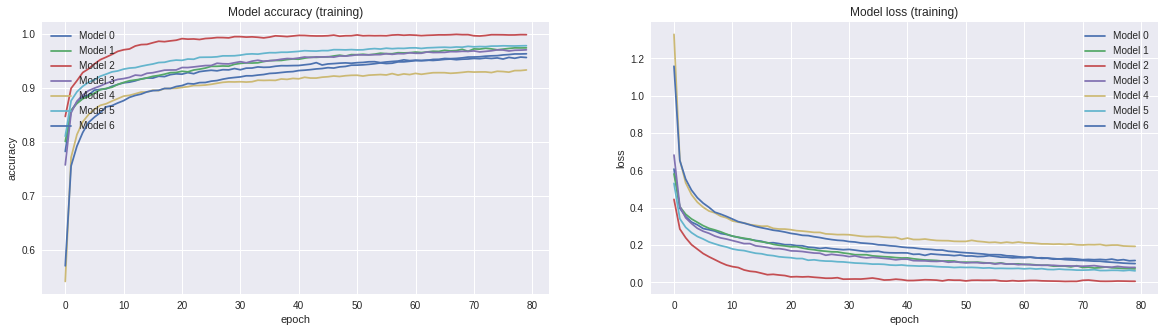

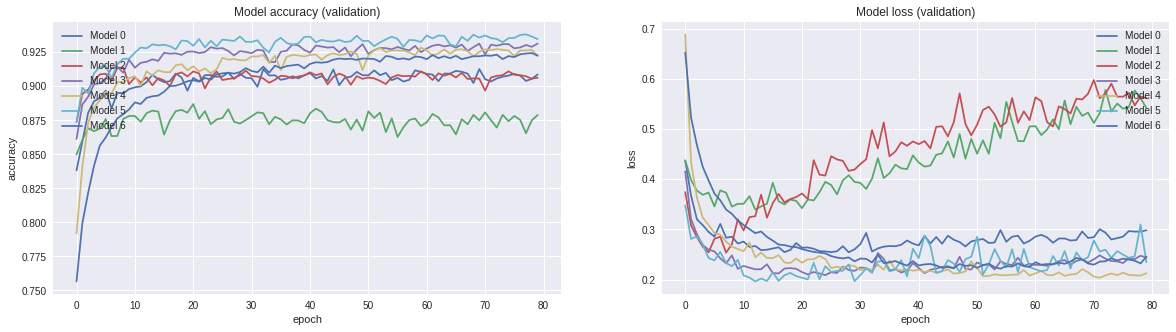

In [37]:
plot_acc_loss('training', histories, 'acc', 'loss')
plot_acc_loss('validation', histories, 'val_acc', 'val_loss')

Grace à ces courbes, on remarque que dans le modèle 1 et le modèle 2 apparait du sur apprentissage très rapidement (à partir de la 10 eme epoch). On va donc s'intéressé au modèles 0,3,4.
Parmi ces 3 modèle, le model 0 présente la moins bonne accuracy, et le plus de pertes. Enfin on trouver des résultats très similaires entre le modèle 3 et 4. Le modèle 3 comporte moins de neurones que le modèle 4 donc il est plus rapide a entrainé comme le montre les temps d'exécution entre chaque epoches.

Dans la suite de code on va donc faire des mesures approfondi pour départager le model 3 et 4



Evaluation du model 3

In [0]:
RUN = 5 # you can choose one of the different models trained above
model = create_model_5()
model.load_weights("fashion_mnist-%i.hdf5" % RUN)
predictions = model.predict_classes(test_data_shaped, verbose=0)


Plotting accuracy and loss for one model

In [0]:
def plot_train_val(title, history):
    fig, (ax1, ax2) = plt.subplots(1, 2)

    # Accuracy
    ax1.set_title('Model accuracy - %s' % title)
    ax1.plot(history['acc'])
    ax1.plot(history['val_acc'])
    ax1.set_xlabel('epoch')
    ax1.set_ylabel('accuracy')
    ax1.legend(['train', 'validation'], loc='upper left')

    # Loss
    ax2.set_title('Model loss - %s' % title)
    ax2.plot(history['loss'])
    ax2.plot(history['val_loss'])
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('loss')
    ax2.legend(['train', 'validation'], loc='upper left')

    fig.set_size_inches(20, 5)
    plt.show()

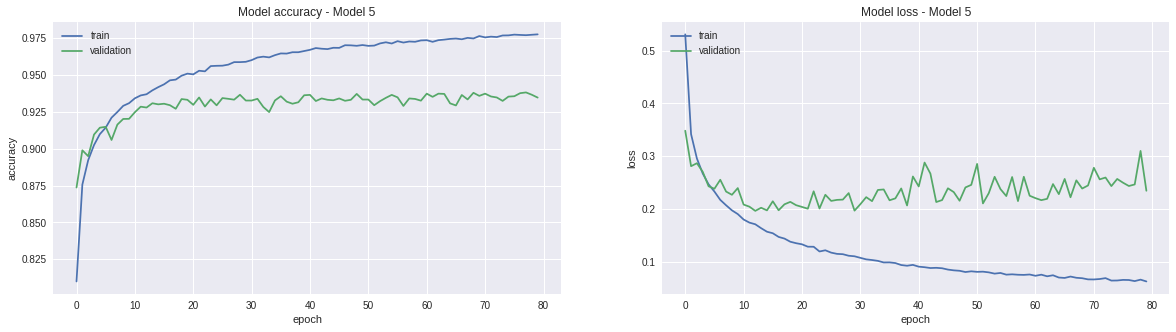

In [40]:
plot_train_val('Model %i' % RUN, histories[RUN])

### affichage des prédiction

In [0]:
def plot_sample_predictions(classes, model, X_test, y_test):
    """
    This function displays images randomly and tries to predict the correct class
    """

    class_ = 0
    images_per_row = 5
    rows = len(classes) / images_per_row

    for i in range(rows):
        fig, axis = plt.subplots(1, images_per_row)

        for i, axis in enumerate(axis):
            start = 0
            end   = len(y_test)
            random = randint(start, end)
            X = X_test[random]
            y = y_test[random]
            X_shaped, _ = shaping([X_test[random]], [y_test[random]])

            fig.set_size_inches(10, 20)
            axis.text(0,32,'Predicted: {}'.format(classes[np.argmax(model.predict(X_shaped))]))
            axis.text(0,36,'Correct: {}'.format((classes)[y]))
            X=X.reshape(28,28)
            axis.imshow(X, cmap='gray')
            axis.axis('off')
            class_ +=1
    plt.show()

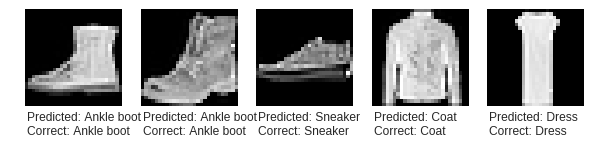

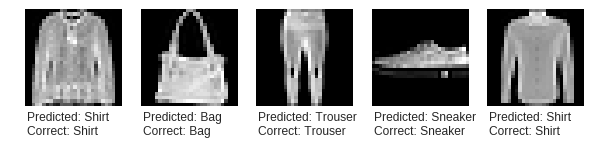

In [42]:
plot_sample_predictions(classes_fashion, model, test_data, test_target)

### affichege matrice de confusion

In [0]:
def plot_confusion_matrix(cm,class_,title='Confusion matrix',cmap=plt.cm.Reds):
    """
    This function plots a confusion matrix
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(class_))
    plt.xticks(tick_marks, class_, rotation=90)
    plt.yticks(tick_marks, class_)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.show()

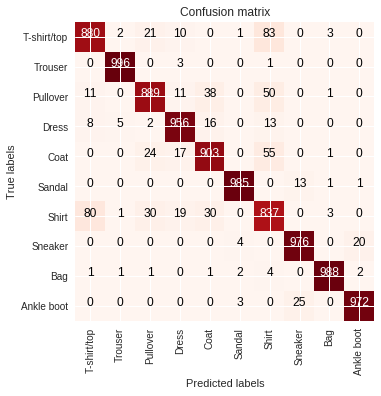

In [44]:
plot_confusion_matrix(confusion_matrix(test_target, predictions), classes_fashion)

On remarque que le modèle a des difficultés a discerné les shurtes qui peut se comprendre car ils ont une forme très similaire avec les t-shirt, et les pullovers.

En visualisant les image a l'oeil nue avec la qualité de 28*28 on a aussi du mal à discerné certain vêtement donc les résultats sin tout à fait acceptable.


##### Report with f1, prec, rec

In [45]:
print classification_report(test_target, predictions)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1000
           1       0.99      1.00      0.99      1000
           2       0.92      0.89      0.90      1000
           3       0.94      0.96      0.95      1000
           4       0.91      0.90      0.91      1000
           5       0.99      0.98      0.99      1000
           6       0.80      0.84      0.82      1000
           7       0.96      0.98      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.98      0.97      0.97      1000

   micro avg       0.94      0.94      0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

